In [48]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

from scipy.linalg import eig
import osmnx as ox

In [49]:
# =============================================================================
# Create the network

# G = nx.DiGraph()
# G.add_edges_from([(0,1), (1,0), (1,2), (2,3), (2,1), (1,3), (3,2)])
# nx.draw(G, with_labels=True, node_color='dodgerblue', node_size=100,width=2,edge_color='0.5',linewidths=1,edgecolors='b')

# =============================================================================
def Graph_to_global_time(G):
    n = nx.number_of_nodes(G)
    node_order = list(G.nodes())

    # Construct the transition matrix P
    A = nx.to_numpy_array(G, nodelist=node_order, weight=None, dtype=int)
    rowsums = np.sum(A, axis=1)
    delta = np.diag(1/rowsums)
    # the transition probability is a fraction of the out degree
    P = np.matmul(delta,A) # stochastic by rows

    # =============================================================================
    # Construct the fundamental matrix Z
    I = np.identity(n, dtype=int)
    e = np.ones(n, dtype=int)

    # calculate the stationary vector pi
    ev,lv = eig(P,left=True, right=False) # eig values and left eig vectors
    ix = np.argsort(ev)[-1] # dominant eigvalue index
    dom_eigenvector = lv[:,ix].real
    pi = (1/np.sum(dom_eigenvector))*dom_eigenvector # probabiltiy vector

    W = np.outer(e,pi) # pi in every row
    Z = np.linalg.inv(I - P + W)

    # =============================================================================
    # Construct the mean first passage matrix M
    E = np.ones((n,n), dtype=int)
    Z_diag = np.diag(np.diag(Z))
    D = np.diag(1/pi)
    mat1 = (I - Z + np.matmul(E,Z_diag))
    M = np.matmul(mat1,D)
    np.fill_diagonal(M, 0) # set M[i][i]=0

    # =============================================================================
    # Calculate the global time tau
    pi_mat = np.outer(pi,e) # pi in every column
    tau_mat = pi_mat * M 
    tau_i = np.sum(tau_mat,axis=0) # vector of tau values
    tau_global = np.sum(tau_i) / n

    return tau_global

In [50]:
edgelist = [
    (0,1),
    (0,2),
    (1,0),
    (1,2),
    (2,0),
    (2,1),
    (3,4),
    (3,5),
    (4,3),
    (4,5),
    (5,4),
    (5,3),
    (2,3),
    (3,2)
]


G = nx.from_edgelist(edgelist, create_using=nx.DiGraph)
A = nx.to_numpy_array(G)

# nx.draw(G, with_labels=True, node_color='dodgerblue', node_size=100,width=2,edge_color='0.5',linewidths=1,edgecolors='b')
# fig = plt.gcf()
# fig.show()
Orig_global_time = Graph_to_global_time(G)
print(Orig_global_time)

8.1984126984127


In [51]:
cmap = plt.cm.viridis

weight_dict = {}
for edge in edgelist:
    if not (edge == (3,2) or edge == (2,3)):
        G.remove_edge(edge[0], edge[1])
        # print(f'Removed edge: {edge}')
        global_time_diff = round(Graph_to_global_time(G)-Orig_global_time, 2)
        print(f'Global time difference after removal of edge {edge}: {global_time_diff}')
        G.add_edge(edge[0], edge[1])
        weight_dict[edge] = global_time_diff
weight_dict[(3,2)] = 0
weight_dict[(2,3)] = 0 
# edge_colors = [cmap(weight_dict[edge]) for edge in weight_dict]
# nx.draw(G, edge_color=edge_colors, with_labels=True, node_color='dodgerblue', node_size=1000,width=3,linewidths=1,edgecolors='b')


Global time difference after removal of edge (0, 1): -0.04
Global time difference after removal of edge (0, 2): 1.51
Global time difference after removal of edge (1, 0): -0.04
Global time difference after removal of edge (1, 2): 1.51
Global time difference after removal of edge (2, 0): 1.07
Global time difference after removal of edge (2, 1): 1.07
Global time difference after removal of edge (3, 4): 1.07
Global time difference after removal of edge (3, 5): 1.07
Global time difference after removal of edge (4, 3): 1.51
Global time difference after removal of edge (4, 5): -0.04
Global time difference after removal of edge (5, 4): -0.04
Global time difference after removal of edge (5, 3): 1.51


{(0, 1): Text(-0.7889717712496462, -0.8196725353246663, '-0.04'),
 (0, 2): Text(-0.6525001400480169, -0.49051206380726387, '1.51'),
 (1, 0): Text(-0.7889717712496462, -0.8196725353246663, '-0.04'),
 (1, 2): Text(-0.4652580039853251, -0.6707407315347848, '1.51'),
 (2, 0): Text(-0.6525001400480169, -0.49051206380726387, '1.07'),
 (2, 1): Text(-0.4652580039853251, -0.6707407315347848, '1.07'),
 (3, 4): Text(0.6519671060565044, 0.4904626653333573, '1.07'),
 (3, 5): Text(0.4652289439389421, 0.6702059495703296, '1.07'),
 (4, 3): Text(0.6519671060565044, 0.4904626653333573, '1.51'),
 (4, 5): Text(0.7895338652875405, 0.8202567157630276, '-0.04'),
 (5, 4): Text(0.7895338652875405, 0.8202567157630276, '-0.04'),
 (5, 3): Text(0.4652289439389421, 0.6702059495703296, '1.51'),
 (3, 2): Text(-0.0005620940378949224, -0.0005841804383614757, '0'),
 (2, 3): Text(-0.0005620940378949224, -0.0005841804383614757, '0')}

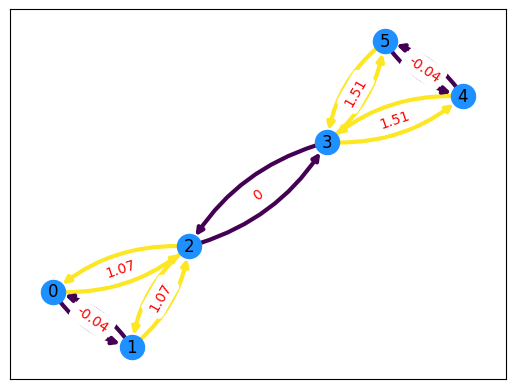

In [52]:
pos = nx.spring_layout(G)  # layout

# Map weights to colors
edge_colors = [cmap(weight_dict[edge]) for edge in G.edges()]

# Draw nodes + labels
nx.draw_networkx_nodes(G, pos, node_color='dodgerblue', node_size=300)
nx.draw_networkx_labels(G, pos)

# Draw edges with colors based on weights
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=3, connectionstyle="arc3,rad=0.2", arrows=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=weight_dict,   # dictionary {(u,v): weight}
    font_color="red",      # customize color
    font_size=10
)


While the previous example shows how removing single edges can leave `traps' for the markov chain to get stuck, and increases distance, the following example shows that replacing bidirected cycles with directed cycles decreases the global time noticeably. Is this always true?

6.083333333333332


C:\Users\mrtim\AppData\Local\Temp\ipykernel_28140\177425931.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


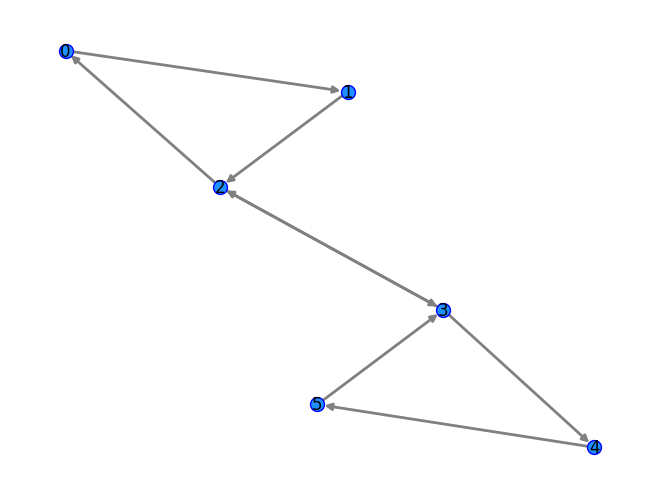

In [53]:
edgelist = [
    (0,1),
    (1,2),
    (2,0),
    (3,4),
    (4,5),
    (5,3),
    (2,3),
    (3,2)
]


G = nx.from_edgelist(edgelist, create_using=nx.DiGraph)
A = nx.to_numpy_array(G)

nx.draw(G, with_labels=True, node_color='dodgerblue', node_size=100,width=2,edge_color='0.5',linewidths=1,edgecolors='b')
fig = plt.gcf()
fig.show()
Orig_global_time = Graph_to_global_time(G)
print(Orig_global_time)

In [54]:
def directed_graph_from_ear_decomposition(G: nx.Graph) -> nx.DiGraph:
    """
    Given a 2-vertex-connected undirected graph G, return a directed graph D
    whose edge orientations correspond to an ear decomposition, chosen so that
    each added ear creates a directed cycle.
    """

    if G.is_directed():
        raise ValueError("Input graph must be undirected")

    if not nx.is_connected(G):
        raise ValueError("Graph must be connected")

    # (Optional but honest check)
    if nx.node_connectivity(G) < 2:
        raise ValueError("Graph must be 2-vertex-connected")

    D = nx.DiGraph()
    D.add_nodes_from(G.nodes())

    # DFS data
    root = next(iter(G.nodes()))
    parent = {root: None}
    depth = {root: 0}

    # Step 1: orient DFS tree edges away from root
    for u, v in nx.dfs_edges(G, root):
        parent[v] = u
        depth[v] = depth[u] + 1
        D.add_edge(u, v)

    # Step 2: orient back edges toward ancestors
    for u, v in G.edges():
        # skip tree edges
        if parent.get(v) == u or parent.get(u) == v:
            continue

        # orient from deeper node to shallower node
        if depth[u] > depth[v]:
            D.add_edge(u, v)
        else:
            D.add_edge(v, u)

    return D

In [55]:

def orient_graph_from_cycle_basis(G: nx.Graph) -> nx.DiGraph:
    """
    Given an undirected graph G, compute a cycle basis and return a directed
    graph where each cycle in the basis is oriented as a directed cycle.

    If an edge appears in multiple cycles, the first orientation is kept.
    """

    if G.is_directed():
        raise ValueError("Input graph must be undirected")

    D = nx.DiGraph()
    D.add_nodes_from(G.nodes())

    # Compute a cycle basis (list of node lists)
    cycles = nx.cycle_basis(G)

    for cycle in cycles:
        k = len(cycle)
        for i in range(k):
            u = cycle[i]
            v = cycle[(i + 1) % k]

            # If neither direction exists yet, orient u -> v
            if not D.has_edge(u, v) and not D.has_edge(v, u):
                D.add_edge(u, v)

    return D


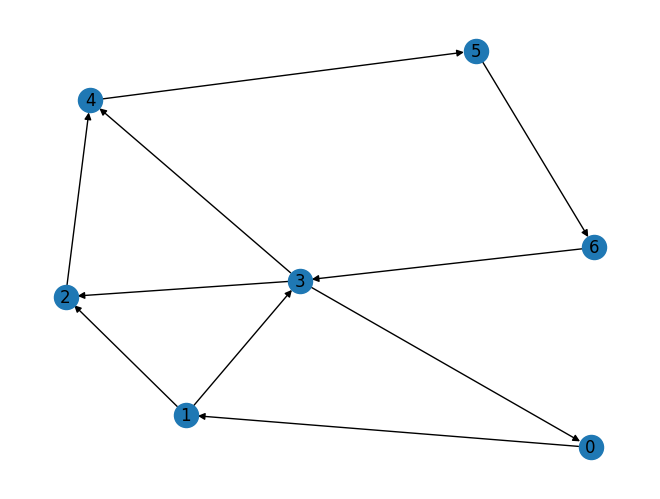

In [56]:

G1 = nx.Graph()

# Left cycle (C4)
G1.add_edges_from([
    (0, 1), (1, 2), (2, 3), (3, 0)
])

# Right cycle (C4)
G1.add_edges_from([
    (3, 4), (4, 5), (5, 6), (6, 3)
])

# Additional edges creating edge redundancy
G1.add_edges_from([
    (1, 3),
    (2, 4)
])


# D = directed_graph_from_ear_decomposition(G1)
D = orient_graph_from_cycle_basis(G1)

nx.draw(D, with_labels=True)


In [57]:
print(Graph_to_global_time(G1))
print(Graph_to_global_time(D))

7.410150375939854
5.352380952380956


In [58]:

G2 = nx.random_planar_graph(30, seed=42)
G2.remove_nodes_from(list(nx.isolates(G2)))

D2 = orient_graph_from_cycle_basis(G2)

nx.draw(D2, with_labels=True)
print(Graph_to_global_time(G2))
print(Graph_to_global_time(D2))

AttributeError: module 'networkx' has no attribute 'random_planar_graph'